In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import pandas as pd
import uproot_methods
import uproot
import awkward
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.config_helpers import *
from Tools.helpers import mergeArray, mt, get_scheduler_address

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [2]:
def pad_and_flatten(val): 
    try:
        return val.pad(1, clip=True).fillna(0.).flatten()#.reshape(-1, 1)
    except AttributeError:
        return val.flatten()

#os.environ['KERAS_BACKEND'] = 'theano'
#from keras.models import load_model

In [3]:
import sys
sys.setrecursionlimit(10000)
print(sys.getrecursionlimit())

10000


In [4]:
from Tools.WH_objects import *
from Tools.WH_scalefactors import LeptonSF
from Tools.WH_deepAK8 import getWTagSF

In [24]:
#global variables... to avoid making bugs!!!
processesList = ['DYJets', 'TTJets', 'ttW', 'ttZ', 'Data']
linesList= ['triggers', 'filters',  'dimuon = 1', 'opposite sign','70 < dimuon mass < 110',
           'lead muon pt > 25', 'sublead muon pt > 15',
            'MET>250', 'N_fatjet>1', 
           'min_dphiFatJetMet4', 'dphiDiFatJet', 'njet veto']
#            'htag > 0', 'minmth>200', '90 < h sd mass > 150',
plotDir = '/home/users/mbryson/public_html/dump/WH/WH_2018/2_1_21/'
year = 2018

In [25]:
class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        ## load b-tag SFs
        #self.btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/data/DeepCSV_102XSF_V1.btag.csv.gz", "reshape")

        ## load the NN
        #self.model = load_model('../ML/data/training.h5')
        #self.stds  = pd.read_json('../ML/data/stds.json').squeeze()
        #self.means = pd.read_json('../ML/data/means.json').squeeze()
        
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"Mass (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        phi_axis            = hist.Bin("phi",       r"$\phi$", 40, -4, 4)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "met":                     hist.Hist("Counts", dataset_axis, pt_axis),
            "met-muon":                hist.Hist("Counts", dataset_axis, pt_axis),
            "met_SR":                  hist.Hist("Counts", dataset_axis, pt_axis),
            "nW":                      hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "nH":                      hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "leadmu_pt":               hist.Hist("Counts", dataset_axis, pt_axis),
            "leadmu_eta":              hist.Hist("Counts", dataset_axis, eta_axis),
            "leadmu_phi":              hist.Hist("Counts", dataset_axis, phi_axis),
            "subleadmu_pt":            hist.Hist("Counts", dataset_axis, pt_axis),
            "subleadmu_eta":           hist.Hist("Counts", dataset_axis, eta_axis),
            "subleadmu_phi":           hist.Hist("Counts", dataset_axis, phi_axis),
            "mm_deltaPhi":             hist.Hist("Counts", dataset_axis, delta_axis),
            "mm_deltaR":               hist.Hist("Counts", dataset_axis, delta_axis),
            "mm_mass":                 hist.Hist("Counts", dataset_axis, mass_axis),
            "mm_pt":                   hist.Hist("Counts", dataset_axis, pt_axis),
            "mm_eta":                  hist.Hist("Counts", dataset_axis, eta_axis),
            "mm_phi":                  hist.Hist("Counts", dataset_axis, phi_axis),
            "N_AK4" :                  hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK8" :                  hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "leadAK4_pt" :             hist.Hist("Counts", dataset_axis, pt_axis),            
            "leadAK4_eta" :            hist.Hist("Counts", dataset_axis, eta_axis),
            "leadAK4_phi" :            hist.Hist("Counts", dataset_axis, phi_axis),
            "subleadAK4_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),            
            "subleadAK4_eta" :         hist.Hist("Counts", dataset_axis, eta_axis),
            "subleadAK4_phi" :         hist.Hist("Counts", dataset_axis, phi_axis),
            "leadAK8_pt" :             hist.Hist("Counts", dataset_axis, pt_axis),            
            "leadAK8_eta" :            hist.Hist("Counts", dataset_axis, eta_axis),            
            "leadAK8_phi" :            hist.Hist("Counts", dataset_axis, phi_axis), 
            "subleadAK8_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),            
            "subleadAK8_eta" :         hist.Hist("Counts", dataset_axis, eta_axis),            
            "subleadAK8_phi" :         hist.Hist("Counts", dataset_axis, phi_axis),
            "min_dphiFatJetMet4":      hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiFatJet":            hist.Hist("Counts", dataset_axis, delta_axis),
            "min_drFatJetLeadMuon":    hist.Hist("Counts", dataset_axis, delta_axis),
            "min_drFatJetSubLeadMuon": hist.Hist("Counts", dataset_axis, delta_axis),
             
            'TTJets':           processor.defaultdict_accumulator(int),
            'DYJets':           processor.defaultdict_accumulator(int),
            'ttW':              processor.defaultdict_accumulator(int),
            'ttZ':              processor.defaultdict_accumulator(int),
            'Data':             processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ############## MET ##############
        met = JaggedCandidateArray.candidatesfromcounts(
            (df['MET_pt']>=0)*1,
            pt = df["MET_pt"],
            eta = df["MET_phi"]*0,
            phi = df["MET_phi"],
            mass = df["MET_phi"]*0
        )
        
        
        ############## LOAD OBJECTS ############## 
        
        muon     = getMuons(df, WP='veto')
        electron = getElectrons(df, WP='veto')
        tau      = getTaus(df)
        isotrack = getIsoTracks(df)
        fatjet   = getFatJets(df)
        jet      = getJets(df)
        
        triggers = getDimuonTriggers(df, year=year, dataset=dataset)
        filters  = getFilters(df, year=year, dataset=dataset)
        
        sf = LeptonSF(year=year)
        leptonSF = sf.get(electron, muon)

        ############## LEPTONS ############## 
    
        high_pt_e = electron[electron.pt.argsort(ascending=False)][:,:2]
        ee = high_pt_e.choose(2)
        
        muon = muon[muon.pt.argsort(ascending=False)]
                
        leadm = muon[:,:1]
        subleadm = muon[:,1:2]
        mm = muon.choose(2)
        newmet = mm.cross(met)
        
        mm_deltaPhi = np.arccos(np.cos(mm.i0.phi-mm.i1.phi))
        mm_deltaR = mm.i0.p4.delta_r(mm.i1.p4)

        

        
        ############## FATJETS ##############
        
        fatjet       = fatjet[~fatjet.match(muon, deltaRCut=0.8)] # remove jets that overlap with muons
        fatjet       = fatjet[~fatjet.match(electron, deltaRCut=0.8)]
        
        high_pt_fatjet = fatjet[fatjet.pt.argsort(ascending=False)][:,:2]
        leadfatjet = high_pt_fatjet[high_pt_fatjet.pt.argmax()]
        subleadfatjet = high_pt_fatjet[high_pt_fatjet.pt.argmin()]
        
        leadingFatJets = fatjet[:,:2]
        difatjet = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjet.i0.phi-difatjet.i1.phi))
        
        htag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        htag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        
        lead_htag = htag[htag.pt.argmax()]
        
        wtag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        wtag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        
        lead_wtag = wtag[wtag.pt.argmax()]
        
        wh = lead_htag.cross(lead_wtag)
        wh_deltaPhi = np.arccos(wh.i0.phi - wh.i1.phi)
        wh_deltaR = wh.i0.p4.delta_r(wh.i1.p4)
        
        ############## JETS ##############

        skimjet   = jet[(jet.pt>30) & (abs(jet.eta)<2.4)]
        jet       = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron, deltaRCut=0.4)]
#        jet       = jet[~jet.match(fatjet, deltaRCut=1.2)]# remove jets that overlap with electrons
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        btag      = jet[(jet.btagDeepB>0.4184)]
        light     = jet[(jet.btagDeepB<0.4184)]
        extrajet  = jet[~jet.match(fatjet, deltaRCut=0.8)] # remove AK4 jets that overlap with AK8 jets
        
        ## Get leading jets
        
        jet = jet[jet.pt.argsort(ascending=False)]
        leadjet = jet[:,:1]
        subleadjet = jet[:,1:2]
        
        ## Get the leading b-jets
        high_score_btag = jet[jet.btagDeepB.argsort(ascending=False)][:,:2]

        leading_b      = btag[btag.pt.argmax()]
        
        bb = high_score_btag.choose(2)
        bb_deltaPhi = np.arccos(np.cos(bb.i0.phi-bb.i1.phi))
        bb_deltaR = bb.i0.p4.delta_r(bb.i1.p4)

        ############## OTHER VARIABLES ##############
        
        ht = jet.pt.sum()
                
        leadingJets = jet[:,:2]
        dijet = leadingJets.choose(2)
        dphiDiJet = np.arccos(np.cos(dijet.i0.phi-dijet.i1.phi))

        min_dphiFatJetMet4 = np.arccos(np.cos(fatjet[:,:4].phi-newmet.phi.min())).min()


        min_drfatjetleadmuon = (np.sqrt((fatjet[:,:4].eta - leadm.eta.min())** 2 + np.arccos(np.cos(fatjet[:,:4].phi-leadm.phi.min()))** 2)).min()
        min_drfatjetsubleadmuon = (np.sqrt((fatjet[:,:4].eta - subleadm.eta.min())** 2 + np.arccos(np.cos(fatjet[:,:4].phi-subleadm.phi.min()))** 2)).min()

        mth = mt(htag.pt, htag.phi, newmet.pt.min(), newmet.phi.min())

        ############## SELECTIONS ##############
        
        dilep_sel = ((electron.counts+muon.counts)==2)
        dilep_sf_sel = dilep_sel & ((electron.counts ==2 )|(muon.counts == 2))
        dilep_of_sel = dilep_sel & ((electron.counts ==1 )|(muon.counts == 1))
        
        dimuon_sel = dilep_sel & (muon.counts == 2)
        
        ak4_sel = (jet.counts > 1)
        ak8_sel = (fatjet.counts > 0)
        
        dimuonmass_sel = (abs(mm.mass-90) < 20).any()
        dimuonpt_sel = (mm.pt > 200).any()
        leadmuon_sel = (leadm.pt > 25).any()
        subleadmuon_sel = (subleadm.pt > 15).any()
        os_sel = ((muon[muon.pdg < 0].counts == 1) & (muon[muon.pdg > 0].counts == 1))

        SR_sel = triggers & filters & ((met.pt >250).any()) &(skimjet.counts >1) 
        SR_sel &= (electron.counts == 0) & (muon.counts == 0) & (muon.counts == 0) 
        SR_sel &= (tau.counts == 0) & (isotrack.counts == 0) & (fatjet.counts > 1)  
        SR_sel &= (min_dphiFatJetMet4>0.5)& ((dphiDiFatJet<2.5).all())  
        SR_sel &= (htag.counts>0) & (wtag.counts>0) & (mth.min()>200)  
        SR_sel &= (abs(htag.msoftdrop-125<25).any()) & (abs(wtag.msoftdrop-80<30).any())  
        SR_sel &= (extrajet.counts<2)
        
        ############## CUTFLOW ##############
        
#         hlt_mu17 = df["HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL"]
#         hlt_mu17_dz = df["HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ"]
#         hlt_mu50 = df["HLT_Mu50"]
#         hlt_mu55 = df["HLT_Mu55"]
#         dimuon_tsel = ((hlt_mu17 == 1) | (hlt_mu17_dz == 1) | (hlt_mu50 == 1) | (hlt_mu55 ==1))
        
        output['totalEvents']['all'] += len(df['weight'])
        processes = processesList
        weight = np.ones(len(df['weight'])) if dataset=='Data' else df['weight']*leptonSF*df['puWeight']
        lumis       = {2016: 36., 2017: 41.5, 2018: 60.}
        cfg['lumi'] = 1 if dataset=='Data' else lumis[year]
        fullweight  = weight*cfg['lumi']

        cutflow = Cutflow(output, df, cfg, processes, weight=weight)
        
        cutflow.addRow( 'triggers',   (triggers) )         
        cutflow.addRow( 'filters',   (filters) ) 
        cutflow.addRow('dimuon = 1', (dimuon_sel))
        cutflow.addRow('opposite sign', (os_sel))        
        cutflow.addRow('70 < dimuon mass < 110', (dimuonmass_sel))
        cutflow.addRow('lead muon pt > 25', (leadmuon_sel))
        cutflow.addRow('sublead muon pt > 15', (subleadmuon_sel))
        cutflow.addRow( 'MET>250',     (newmet.pt>250).any() )
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'min_dphiFatJetMet4', (min_dphiFatJetMet4>0.5))
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) 
        cutflow.addRow( 'njet veto',     (extrajet.counts<2))

#        cutflow.addRow('dimuon pt > 200', (dimuonpt_sel))       
#         cutflow.addRow( 'stitch',   (stitchVar ==1) )
#         cutflow.addRow( 'skim',   ((met_pt>200) & (skimjet.counts>1)) )
#         cutflow.addRow( 'Exactly 1 e or mu',   ((electron.counts+muon.counts)==1) )
# 
        
        baseline = copy.deepcopy(cutflow.selection)

       ############## HISTOGRAMS ##############
        output['met'].fill(dataset=dataset,pt=met[baseline].pt.flatten(),weight=fullweight[baseline])
        output['met_SR'].fill(dataset=dataset,pt=met[SR_sel].pt.flatten(),weight=fullweight[SR_sel])
        output['met-muon'].fill(dataset=dataset,pt=newmet[baseline].pt.flatten(),weight=fullweight[baseline])
        output['nW'].fill(dataset=dataset, multiplicity=wtag[baseline].counts, weight=fullweight[baseline])       
        output['nH'].fill(dataset=dataset, multiplicity=htag[baseline].counts, weight=fullweight[baseline])       
        output['mm_mass'].fill(dataset=dataset,mass=mm[baseline].mass.flatten(),weight=fullweight[baseline])
        output['mm_pt'].fill(dataset=dataset,pt=mm[baseline].pt.flatten(),weight=fullweight[baseline])
        output['mm_eta'].fill(dataset=dataset,eta=mm[baseline].eta.flatten(),weight=fullweight[baseline])
        output['mm_phi'].fill(dataset=dataset,phi=mm[baseline].phi.flatten(),weight=fullweight[baseline])
        output['leadmu_pt'].fill(dataset=dataset,pt=leadm[baseline].pt.flatten(),weight=fullweight[baseline])
        output['leadmu_eta'].fill(dataset=dataset,eta=leadm[baseline].eta.flatten(),weight=fullweight[baseline])
        output['leadmu_phi'].fill(dataset=dataset,phi=leadm[baseline].phi.flatten(),weight=fullweight[baseline])
        output['subleadmu_pt'].fill(dataset=dataset,pt=subleadm[baseline].pt.flatten(),weight=fullweight[baseline])
        output['subleadmu_eta'].fill(dataset=dataset,eta=subleadm[baseline].eta.flatten(),weight=fullweight[baseline])
        output['subleadmu_phi'].fill(dataset=dataset,phi=subleadm[baseline].phi.flatten(),weight=fullweight[baseline])
        output['mm_deltaPhi'].fill(dataset=dataset, delta=mm_deltaPhi[baseline].flatten(), weight=fullweight[baseline])
        output['mm_deltaR'].fill(dataset=dataset, delta=mm_deltaR[baseline].flatten(), weight=fullweight[baseline])
        output['N_AK4'].fill(dataset=dataset, multiplicity=jet[baseline].counts, weight=fullweight[baseline])
        output['N_AK8'].fill(dataset=dataset, multiplicity=fatjet[baseline].counts, weight=fullweight[baseline])       
        output['leadAK4_pt'].fill(dataset=dataset, pt=leadjet[baseline & ak4_sel].pt.flatten(), weight=fullweight[baseline & ak4_sel])
        output['leadAK4_eta'].fill(dataset=dataset, eta=leadjet[baseline & ak4_sel].eta.flatten(), weight=fullweight[baseline & ak4_sel])
        output['leadAK4_phi'].fill(dataset=dataset, phi=leadjet[baseline & ak4_sel].phi.flatten(), weight=fullweight[baseline & ak4_sel])
        output['subleadAK4_pt'].fill(dataset=dataset, pt=subleadjet[baseline & ak4_sel].pt.flatten(), weight=fullweight[baseline & ak4_sel])
        output['subleadAK4_eta'].fill(dataset=dataset, eta=subleadjet[baseline & ak4_sel].eta.flatten(), weight=fullweight[baseline & ak4_sel])
        output['subleadAK4_phi'].fill(dataset=dataset, phi=subleadjet[baseline & ak4_sel].phi.flatten(), weight=fullweight[baseline & ak4_sel])
        output['leadAK8_pt'].fill(dataset=dataset, pt=leadfatjet[baseline & ak8_sel].pt.flatten(), weight=fullweight[baseline & ak8_sel])       
        output['leadAK8_eta'].fill(dataset=dataset, eta=leadfatjet[baseline & ak8_sel].eta.flatten(), weight=fullweight[baseline & ak8_sel])       
        output['leadAK8_phi'].fill(dataset=dataset, phi=leadfatjet[baseline & ak8_sel].phi.flatten(), weight=fullweight[baseline & ak8_sel])       
        output['subleadAK8_pt'].fill(dataset=dataset, pt=subleadfatjet[baseline & ak8_sel].pt.flatten(), weight=fullweight[baseline & ak8_sel])       
        output['subleadAK8_eta'].fill(dataset=dataset, eta=subleadfatjet[baseline & ak8_sel].eta.flatten(), weight=fullweight[baseline & ak8_sel])       
        output['subleadAK8_phi'].fill(dataset=dataset, phi=subleadfatjet[baseline & ak8_sel].phi.flatten(), weight=fullweight[baseline & ak8_sel])       
        output['min_dphiFatJetMet4'].fill(dataset=dataset, delta=min_dphiFatJetMet4[baseline].flatten(), weight=fullweight[baseline])
        output['dphiDiFatJet'].fill(dataset=dataset, delta=dphiDiFatJet[(baseline & (fatjet.counts>1))].min().flatten(), weight=fullweight[baseline & (fatjet.counts>1)])
        output['min_drFatJetLeadMuon'].fill(dataset=dataset, delta=min_drfatjetleadmuon[baseline].flatten(), weight=fullweight[baseline])
        output['min_drFatJetSubLeadMuon'].fill(dataset=dataset, delta=min_drfatjetsubleadmuon[baseline].flatten(), weight=fullweight[baseline])

        return output

    def postprocess(self, accumulator):
        return accumulator

In [26]:
runLocal = True

if not runLocal:
    # Get the scheduler from the dask_cluster notebook
    from dask.distributed import Client, progress

    c = Client('tcp://169.228.130.5:27879')

    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor
    
else:
    ## for local
    exe_args = {
        'workers': 16,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor

if not runLocal:
    print(c)

In [27]:
overwrite = True
small = False

tag = 'v0.2.4'

from Tools.dilep_samples import * #fileset_2016, fileset_2016_small

if year == 2016:
    fileset_year = fileset_dilep_2016
    fileset_year_small = fileset_dilep_2016_small
elif year == 2017:
    fileset_year = fileset_dilep_2017
    fileset_year_small = fileset_dilep_2017_small
elif year == 2018:
    fileset_year = fileset_dilep_2018
    fileset_year_small = fileset_dilep_2018_small


fileset_dilep = {
    'DYJets': fileset_year['DY_Tune'],
    'ZNuNu': fileset_year['ZNuNu'],
    'TTJets': fileset_year['TTJets'] ,
    'ttW': fileset_year['TTW'],
    'ttZ': fileset_year['TTZ'],
    'Data': fileset_year['DoubleMuon'],
}


fileset_dilep_small = {
    'DYJets': fileset_dilep['DYJets'][:2],
    'ZNuNu': fileset_dilep['ZNuNu'][:2],
    'TTJets': fileset_dilep['TTJets'][:2],
    'ttW': fileset_dilep['ttW'][:2],
    'ttZ': fileset_dilep['ttZ'][:2],
    'Data': fileset_dilep['Data'][:2],
}

# load the config and the cache
cfg = loadConfig()

cacheName = 'Dilep_%s_small'%year if small else 'DiLep_%s'%year
print(cacheName)

# histograms
histograms = []

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = fileset_dilep_small
        exe_args['workers'] = 4
    else:
        fileset = fileset_dilep
        exe_args['workers'] = 16
    
        
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      #chunksize=250000,
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

DiLep_2018


HBox(children=(HTML(value='Preprocessing'), FloatProgress(value=0.0, max=362.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=1125.0), HTML(value='')))

/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/j

In [28]:
# Cutflow
from Tools.helpers import getCutFlowTable

datapt = 'Data'
puritypt = 'DYJets'


processes = processesList
lines     = ['entry']
lines    += linesList
df        = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4,
                           signal=datapt, purity =puritypt)
df

,DYJets,TTJets,ttW,ttZ,Data,Background,D/B,Purity
entry,94900000.0 +/- 20000.0,2280000.0 +/- 1000.0,6304.0 +/- 4.0,5796.0 +/- 6.0,54520000.0 +/- 10000.0,9.719267e+07,0.5610,0.9764
triggers,94900000.0 +/- 20000.0,2280000.0 +/- 1000.0,6304.0 +/- 4.0,5796.0 +/- 6.0,50950000.0 +/- 10000.0,9.719267e+07,0.5242,0.9764
filters,94880000.0 +/- 20000.0,2279000.0 +/- 1000.0,6289.0 +/- 4.0,5788.0 +/- 6.0,50930000.0 +/- 10000.0,9.717269e+07,0.5241,0.9764
dimuon = 1,49630000.0 +/- 10000.0,542900.0 +/- 300.0,992.3 +/- 1.8,1136.0 +/- 3.0,49470000.0 +/- 10000.0,5.017896e+07,0.9858,0.9891
opposite sign,49590000.0 +/- 10000.0,532100.0 +/- 300.0,647.8 +/- 1.4,1056.0 +/- 2.0,48810000.0 +/- 10000.0,5.012272e+07,0.9737,0.9894
70 < dimuon mass < 110,46950000.0 +/- 10000.0,138500.0 +/- 200.0,159.0 +/- 0.7,772.1 +/- 2.1,41230000.0 +/- 10000.0,4.709380e+07,0.8755,0.9970
lead muon pt > 25,46690000.0 +/- 10000.0,136900.0 +/- 200.0,157.4 +/- 0.7,770.3 +/- 2.1,40900000.0 +/- 10000.0,4.683242e+07,0.8733,0.9971
sublead muon pt > 15,46210000.0 +/- 10000.0,127300.0 +/- 200.0,143.1 +/- 0.7,730.6 +/- 2.0,40410000.0 +/- 10000.0,4.633326e+07,0.8721,0.9972
MET>250,69740.0 +/- 540.0,2342.0 +/- 22.0,13.25 +/- 0.21,94.24 +/- 0.77,61160.0 +/- 250.0,7.219360e+04,0.8471,0.9661
N_fatjet>1,4639.0 +/- 138.0,231.7 +/- 7.0,2.083 +/- 0.082,17.61 +/- 0.37,3792.0 +/- 62.0,4.890360e+03,0.7754,0.9486


In [29]:
# Efficiencies
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, absolute=False)
df

,DYJets,TTJets,ttW,ttZ,Data
entry,1.000,1.000,1.000,1.000,1.000
triggers,1.000,1.000,1.000,1.000,0.934
filters,1.000,0.999,0.998,0.999,1.000
dimuon = 1,0.523,0.238,0.158,0.196,0.971
opposite sign,0.999,0.980,0.653,0.930,0.987
70 < dimuon mass < 110,0.947,0.260,0.246,0.731,0.845
lead muon pt > 25,0.994,0.989,0.990,0.998,0.992
sublead muon pt > 15,0.990,0.929,0.909,0.948,0.988
MET>250,0.002,0.018,0.093,0.129,0.002
N_fatjet>1,0.067,0.099,0.157,0.187,0.062


In [30]:
output['met'].sum('pt').values()

{('DYJets',): 2665.370342333941,
 ('Data',): 2054.0,
 ('TTJets',): 59.51442651878989,
 ('ZNuNu',): 0.0,
 ('ttW',): 0.46205318262041184,
 ('ttZ',): 4.8263638025159885}

In [31]:
output['met_SR'].sum('pt').values()

{('DYJets',): 0.0,
 ('Data',): 5.0,
 ('TTJets',): 0.9869729638449898,
 ('ZNuNu',): 7.663987662887977,
 ('ttW',): 0.7490036042963275,
 ('ttZ',): 0.8826573828204124}

In [32]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [33]:
from plots.helpers import *
bins = {
    'met_axis':                  {'axis':'pt',   'overflow': 'over', 'bins': hist.Bin("pt",  r"$E_{T}^{miss}$ (GeV)", 20, 0, 500)},
    'met-muon_axis':             {'axis':'pt',   'overflow': 'over', 'bins': hist.Bin("pt",  r"$E_{T}^{miss}$ - dimuon $p_T$ (GeV)", 28, 0, 700)},
    'met_coarse':                {'axis': 'pt',   'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', np.array([250,400,600])) },
    'nW_axis':                   {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$nWtag', 4, -0.5, 3.5)},
    'nH_axis':                   {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$nHtag', 4, -0.5, 3.5)},
    'mm_mass_axis':              {'axis':'mass',   'overflow': 'over', 'bins': hist.Bin("mass",  r"Dimuon mass (GeV)", 25, 50, 150)},
    'mm_pt_axis':                {'axis':'pt',   'overflow': 'over', 'bins': hist.Bin("pt",  r"Dimuon $p_{T}$ (GeV)", 25, 0, 300)},
    'mm_eta_axis':               {'axis':'eta',   'overflow': 'over', 'bins': hist.Bin("eta",       r"Dimuon $\eta$", 30, -5.5, 5.5)},
    'mm_phi_axis':               {'axis':'phi',   'overflow': 'over', 'bins': hist.Bin("phi",       r"Dimuon $\phi$", 20, -4, 4)},
    'leadmu_pt_axis':            {'axis':'pt',   'overflow': 'over', 'bins': hist.Bin("pt",  r" Lead Muon $p_{T}$ (GeV)", 25, 0, 250)},
    'leadmu_eta_axis':           {'axis':'eta',   'overflow': 'over', 'bins': hist.Bin("eta",       r"Lead Muon $\eta$", 30, -5.5, 5.5)},
    'leadmu_phi_axis':           {'axis':'phi',   'overflow': 'over', 'bins': hist.Bin("phi",       r"Lead Muon $\phi$", 20, -4, 4)},
    'subleadmu_pt_axis':         {'axis':'pt',   'overflow': 'over', 'bins': hist.Bin("pt",  r" Sublead Muon $p_{T}$ (GeV)", 25, 0, 150)},
    'subleadmu_eta_axis':        {'axis':'eta',   'overflow': 'over', 'bins': hist.Bin("eta",       r"Sublead Muon $\eta$", 30, -5.5, 5.5)},
    'subleadmu_phi_axis':        {'axis':'phi',   'overflow': 'over', 'bins': hist.Bin("phi",       r"Sublead Muon $\phi$", 20, -4, 4)},
    'leadAK4_pt_axis':           {'axis':'pt',   'overflow': 'over', 'bins': hist.Bin("pt",  r" Lead AK4 $p_{T}$ (GeV)", 25, 0, 300)},
    'leadAK4_eta_axis':          {'axis':'eta',   'overflow': 'over', 'bins': hist.Bin("eta",       r"Lead AK4 $\eta$", 30, -5.5, 5.5)},
    'leadAK4_phi_axis':          {'axis':'phi',   'overflow': 'over', 'bins': hist.Bin("phi",       r"Lead AK4 $\phi$", 20, -4, 4)},
    'subleadAK4_pt_axis':        {'axis':'pt',   'overflow': 'over', 'bins': hist.Bin("pt",  r" Sublead AK4 $p_{T}$ (GeV)", 25, 0, 200)},
    'subleadAK4_eta_axis':       {'axis':'eta',   'overflow': 'over', 'bins': hist.Bin("eta",       r"Sublead AK4 $\eta$", 30, -5.5, 5.5)},
    'subleadAK4_phi_axis':       {'axis':'phi',   'overflow': 'over', 'bins': hist.Bin("phi",       r"Sublead AK4 $\phi$", 20, -4, 4)},
    'leadAK8_pt_axis':           {'axis':'pt',   'overflow': 'over', 'bins': hist.Bin("pt",  r" Lead AK8 $p_{T}$ (GeV)", 25, 150, 400)},
    'leadAK8_eta_axis':          {'axis':'eta',   'overflow': 'over', 'bins': hist.Bin("eta",       r"Lead AK8 $\eta$", 30, -5.5, 5.5)},
    'leadAK8_phi_axis':          {'axis':'phi',   'overflow': 'over', 'bins': hist.Bin("phi",       r"Lead AK8 $\phi$", 20, -4, 4)},
    'subleadAK8_pt_axis':        {'axis':'pt',   'overflow': 'over', 'bins': hist.Bin("pt",  r" Sublead AK8 $p_{T}$ (GeV)", 25, 150, 350)},
    'subleadAK8_eta_axis':       {'axis':'eta',   'overflow': 'over', 'bins': hist.Bin("eta",       r"Sublead AK8 $\eta$", 30, -5.5, 5.5)},
    'subleadAK8_phi_axis':       {'axis':'phi',   'overflow': 'over', 'bins': hist.Bin("phi",       r"Sublead AK8 $\phi$", 20, -4, 4)},
    'N_AK4_axis':                {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK8_axis':                {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK8 jet}$', 5, -0.5, 4.5)},
    'mm_deltaPhi_axis':          {'axis': 'delta', 'overflow':'over',  'bins': hist.Bin('delta', r'Dimuon $\Delta \phi $', 30, 0, 3)},
    'mm_deltaR_axis':            {'axis': 'delta', 'overflow':'over',  'bins': hist.Bin('delta', r'Dimuon $\Delta R $', 10, 0, 5)},
    'min_dphiFatJetMet4_axis':   {'axis': 'delta', 'overflow':'over',  'bins': hist.Bin('delta', r'min $\Delta \phi $ (fatjet(4),MET)', 25, 0, 5)},
    'dphiDiFatJet_axis':         {'axis': 'delta', 'overflow':'over',  'bins': hist.Bin('delta', r' $\Delta \phi $ difatjet', 25, 0, 5)},
    'min_drFatJetLeadMuon_axis':   {'axis': 'delta', 'overflow':'over',  'bins': hist.Bin('delta', r'min $\Delta R $ (fatjet(4), Lead Muon)', 25, 0, 5)},
    'min_drFatJetSubLeadMuon_axis':   {'axis': 'delta', 'overflow':'over',  'bins': hist.Bin('delta', r'min $\Delta R $ (fatjet(4), Sublead Muon)', 25, 0, 5)},
   }

In [34]:
#Plotting aesthetics

lineopts = {
    'color': 'r',
    'linewidth': '3'}

data_err_opts = {
    'linestyle': 'none',
    'marker': '_',
    'markersize': 10.,
    'color': 'r',
    'elinewidth': 1}

data_err_opts_rat = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1}

fillopts2 = {
    'edgecolor': (0,0,0,0.3),
    'facecolor': [('#989C94'),('#6A0136'),('#FF5714'),('#FFCA3A')]  
}

In [35]:
from plots.helpers import *

def saveFig( fig, ax, rax, path, name, scale='linear', shape=False, y_max=-1 ):
    outdir = os.path.join(path,scale)
    finalizePlotDir(outdir)
    ax.set_yscale(scale)
    ax.set_ylabel('Events')

    if scale == 'linear':
        if y_max<0: #or True:
            pass
        else:
            ax.set_ylim(0, 1 if shape else 1.2*y_max)
    else:
        if y_max<0 and not shape:
            pass
        else:
            ax.set_ylim(0.000005 if shape else 0.05, 3 if shape else 300*y_max)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for handle, label in zip(handles, labels):
        #print (handle, label)
        try:
            new_labels.append(my_labels[label])
            if not label=='pseudodata':
                handle.set_color(colors[label])
        except:
            pass

    if rax:
        plt.subplots_adjust(hspace=0)
        rax.set_ylabel('Obs./Pred.')
        rax.set_ylim(0,2)

    ax.legend(title='',ncol=2,handles=handles, labels=new_labels, frameon=False)

    fig.text(0., 0.995, '$\\bf{CMS}$', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.15, 1., '$\\it{Preliminary}$', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.8, 1., '13 TeV', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

    fig.savefig(os.path.join(outdir, "{}.pdf".format(name)))
    fig.savefig(os.path.join(outdir, "{}.png".format(name)))
    #ax.clear()

In [36]:
#Histos I want to save
histos = [["mm_mass", "mm_mass_axis"],
        ["mm_pt", "mm_pt_axis"],
        ["mm_eta", "mm_eta_axis"],
        ["mm_phi", "mm_phi_axis"],
        ["leadmu_pt", "leadmu_pt_axis"],
        ["leadmu_eta", "leadmu_eta_axis"],
        ["leadmu_phi", "leadmu_phi_axis"],
        ["subleadmu_pt", "subleadmu_pt_axis"],
        ["subleadmu_eta", "subleadmu_eta_axis"],
        ["subleadmu_phi", "subleadmu_phi_axis"],
        ["leadAK4_pt", "leadAK4_pt_axis"],
        ["leadAK4_eta", "leadAK4_eta_axis"],
        ["leadAK4_phi", "leadAK4_phi_axis"],
        ["subleadAK4_pt", "subleadAK4_pt_axis"],
        ["subleadAK4_eta", "subleadAK4_eta_axis"],
        ["subleadAK4_phi", "subleadAK4_phi_axis"],
        ["leadAK8_pt", "leadAK8_pt_axis"],
        ["leadAK8_eta", "leadAK8_eta_axis"],
        ["leadAK8_phi", "leadAK8_phi_axis"],
        ["subleadAK8_pt", "subleadAK8_pt_axis"],
        ["subleadAK8_eta", "subleadAK8_eta_axis"],
        ["subleadAK8_phi", "subleadAK8_phi_axis"],
        ["N_AK4", "N_AK4_axis"],
        ["N_AK8", "N_AK8_axis"],
        ["mm_deltaPhi", "mm_deltaPhi_axis"],
        ["mm_deltaR", "mm_deltaR_axis"],
        ["met", "met_axis"],
        ["met-muon", "met_coarse"],
        ["nW", "nW_axis"],
        ["nH", "nH_axis"],
        ["min_dphiFatJetMet4", "min_dphiFatJetMet4_axis"],
        ["dphiDiFatJet", "dphiDiFatJet_axis"],
        ["min_drFatJetLeadMuon", "min_drFatJetLeadMuon_axis"],
        ["min_drFatJetSubLeadMuon", "min_drFatJetSubLeadMuon_axis"]]

/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plo

/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/pl

/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/mbryson/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plo

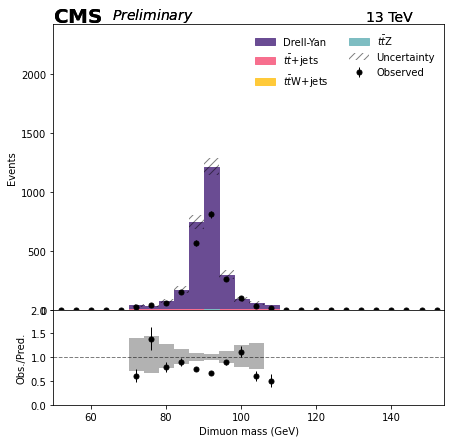

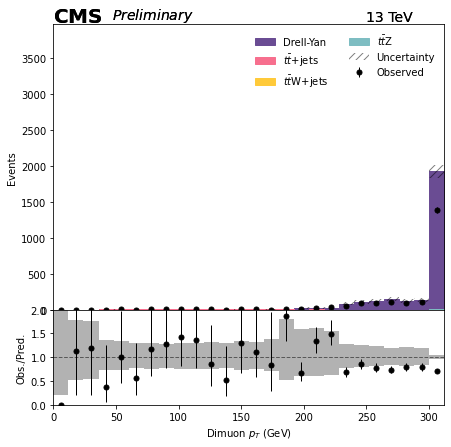

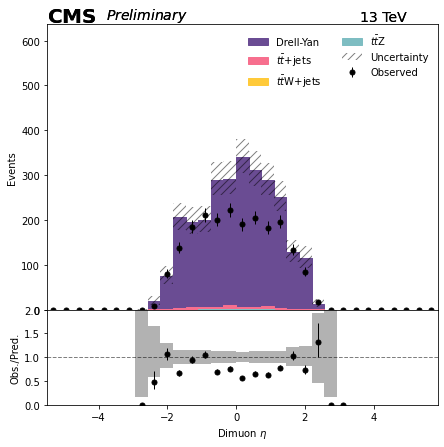

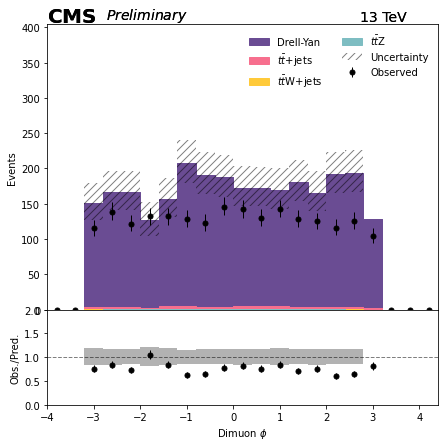

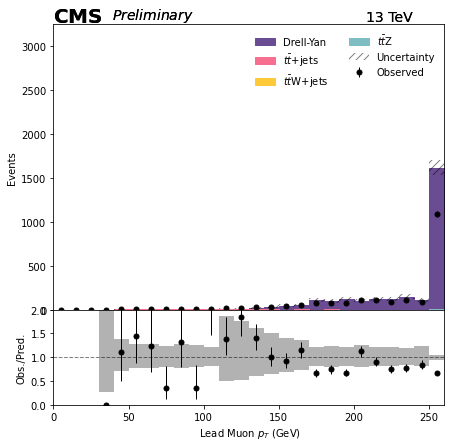

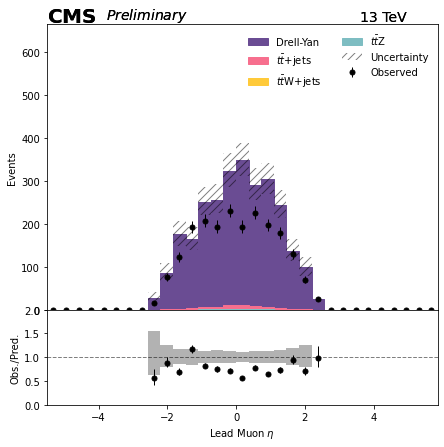

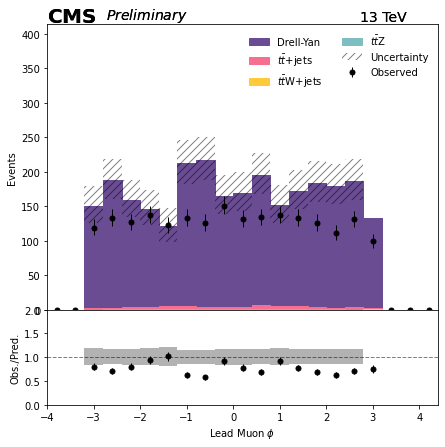

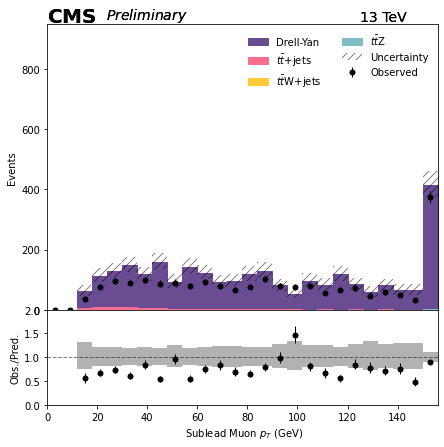

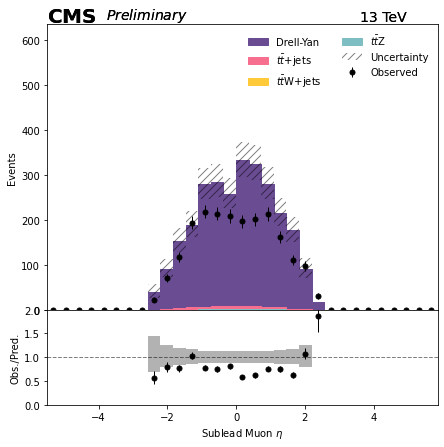

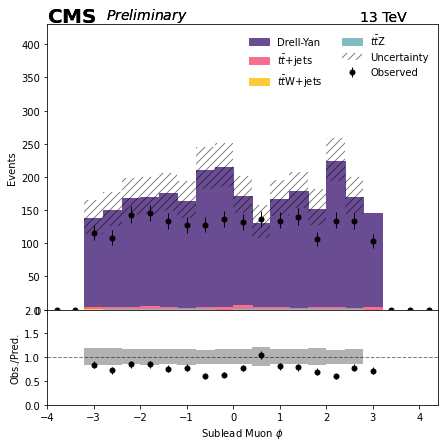

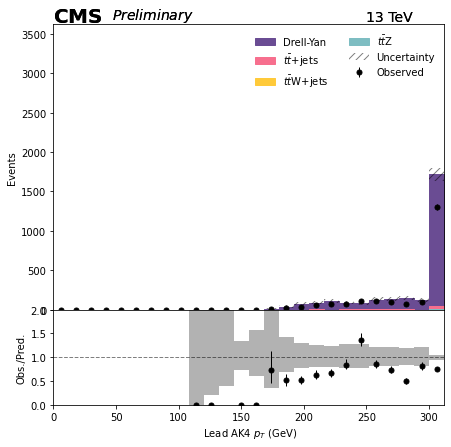

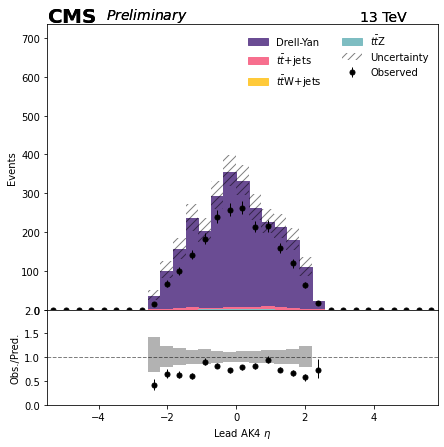

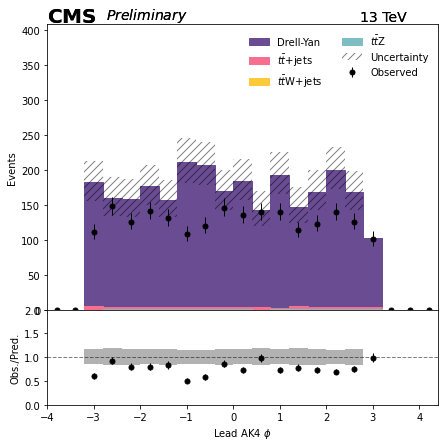

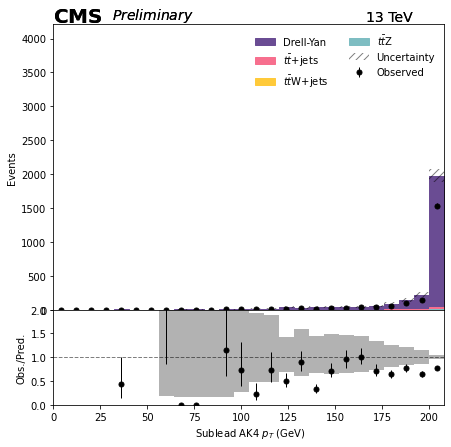

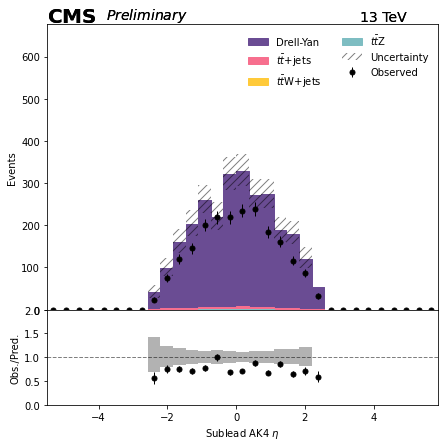

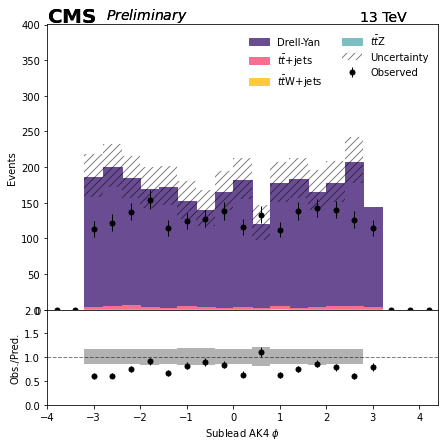

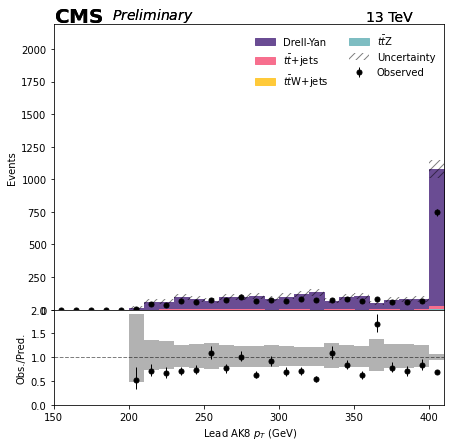

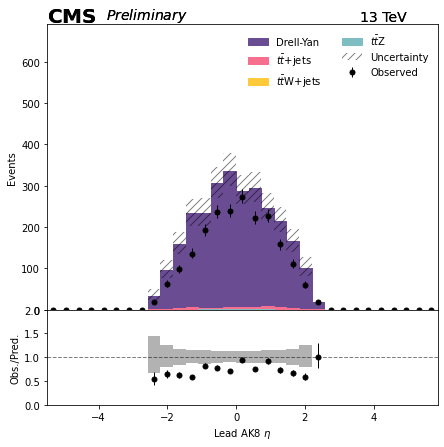

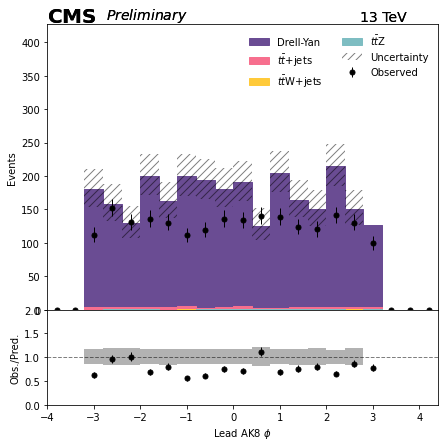

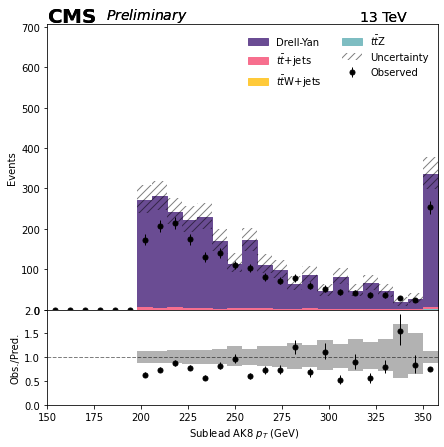

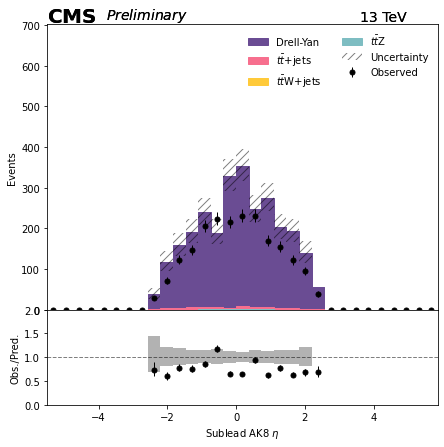

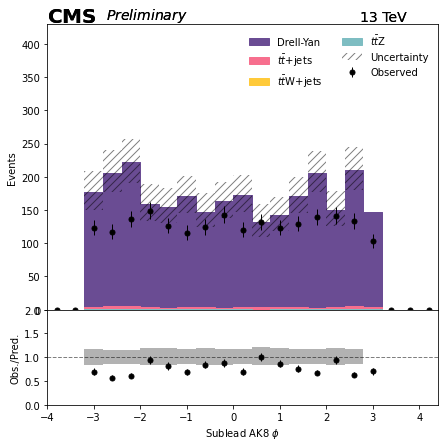

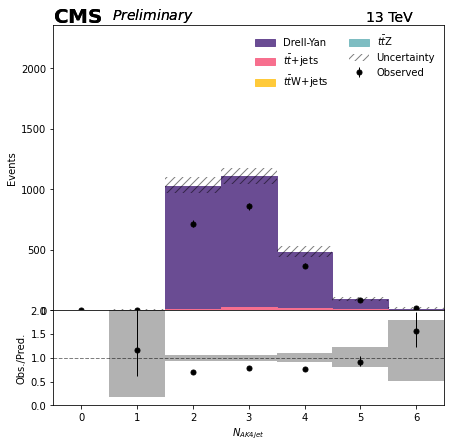

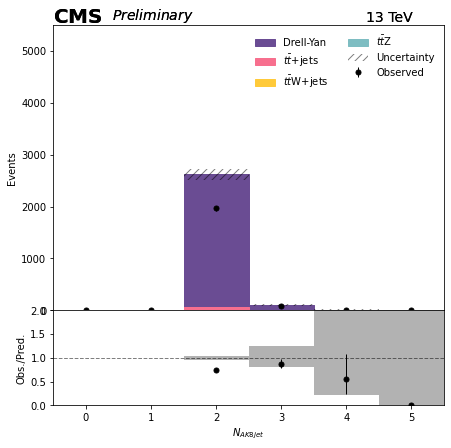

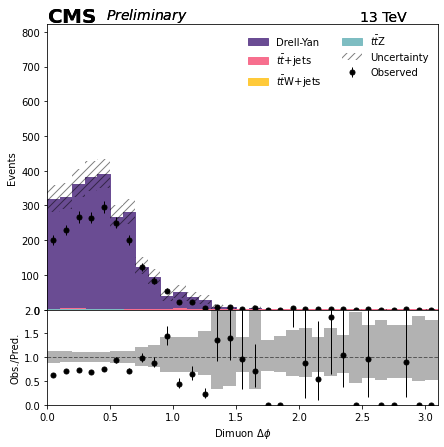

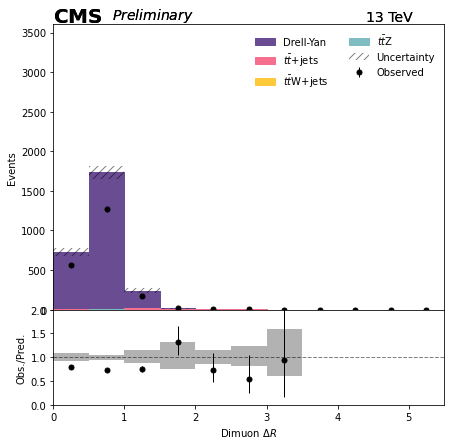

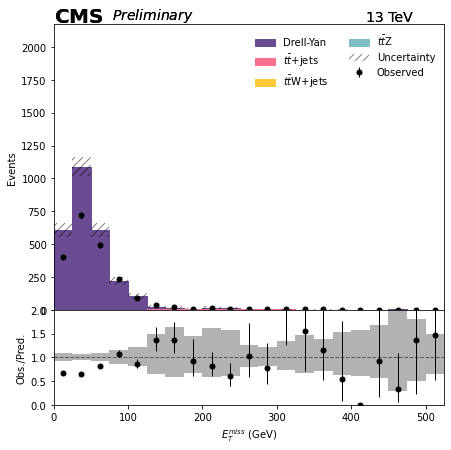

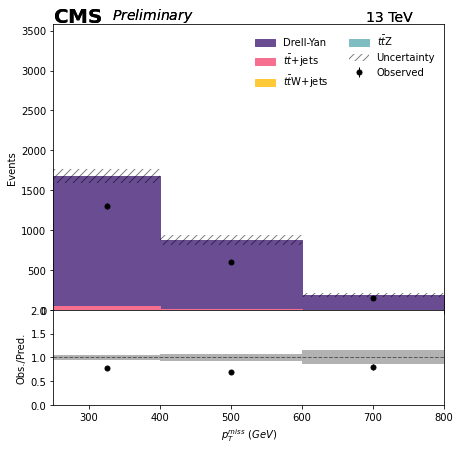

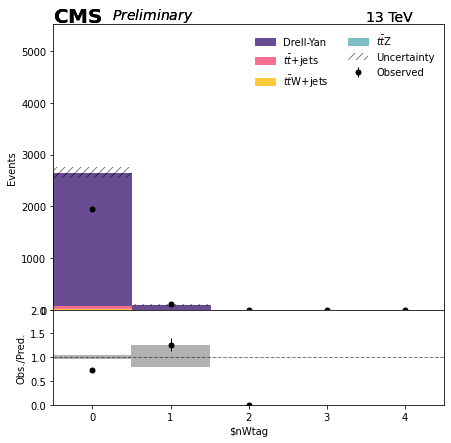

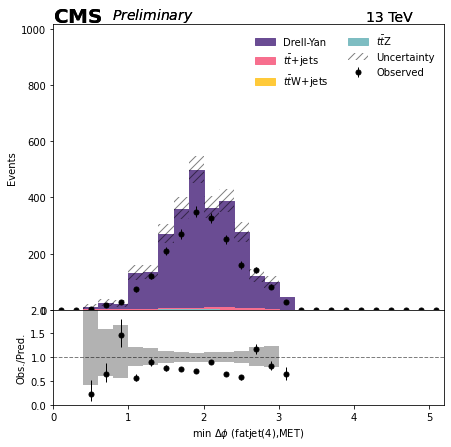

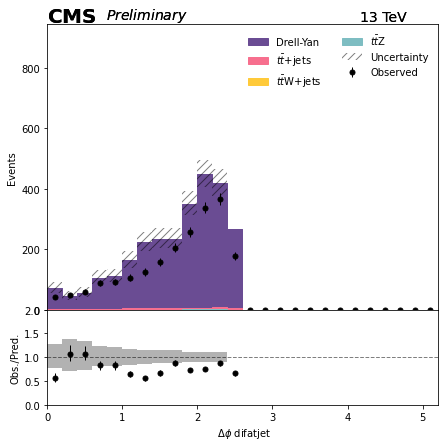

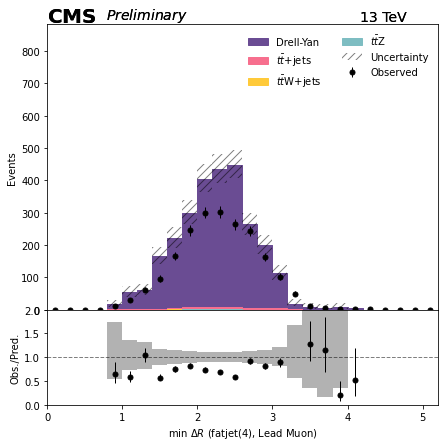

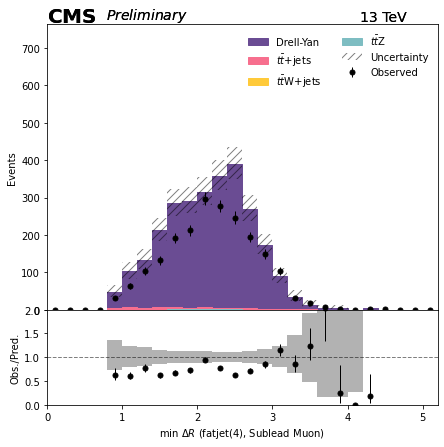

In [37]:
# Make some of the plots


finalizePlotDir(plotDir)


for plot in histos:

    name = plot[0]
    binName = plot[1]
    histogram = output[name]

    axis = bins[binName]['axis']
    histogram = histogram.rebin(axis, bins[binName]['bins'])

    y_max = histogram.sum("dataset").values(overflow='all')[()].max()
    y_over = histogram.sum("dataset").values(overflow='all')[()][-1]

    import re

    bkg = re.compile('(?!Data)')
    
    background = histogram[bkg]
    data = histogram['Data']

    #fig, ax = plt.subplots(1,1,figsize=(7,7))
    fig, (ax, rax) = plt.subplots(nrows=2,ncols=1, figsize=(7,7),
        gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    
    # get axes
    hist.plot1d(background, overlay="dataset", ax=ax, stack=True, 
                overflow=bins[binName]['overflow'], clear=False, 
                fill_opts=fill_opts, error_opts=error_opts,
                order=['ttZ', 'ttW','TTJets', 'DYJets'])
#     hist.plot1d(background, overlay="dataset", ax=ax, stack=True, 
#                  overflow=bins[binName]['overflow'], clear=False, fill_opts=fillopts2) 
#                  #error_opts=error_opts)# order=['DYJets','TTJets', 'ttW', 'ttZ']) #error_opts??
    hist.plot1d(data, overlay="dataset", ax=ax, stack=False, 
                overflow=bins[binName]['overflow'], error_opts=data_err_opts_rat, 
                clear=False)
    hist.plotratio(num=data.sum('dataset'), denom=background.sum('dataset'), ax=rax,
                   error_opts = data_err_opts_rat, denom_fill_opts={}, guide_opts={}, 
                   unc='num', overflow = 'over')

    for l in ['log', 'linear']:
        saveFig(fig, ax, rax, plotDir, name, scale=l, shape=False, y_max=y_max)


# ESTIMATE

In [1]:
from uncertainties import ufloat
## This can be either validation region or signal region

# First, add the years together using the add function of the histograms
# Then, use uncertainties.ufloat to do proper error propagation

def get_np_ufloat(vals):
    print (vals)
    return np.array([ ufloat(vals[0][i], np.sqrt(vals[1][i])) for i in range(len(vals[0]))  ])

In [2]:
hist_SR = output['met_SR'].copy()
hist_CR = output['met'].copy()
axis = bins['met_coarse']['axis']
hist_SR = hist_SR.rebin(axis, bins['met_coarse']['bins'])
hist_CR = hist_CR.rebin(axis, bins['met_coarse']['bins'])


NameError: name 'output' is not defined

In [40]:
bkgonly = re.compile('(?!(Data|ZNuNu))')
CR_bkg  = get_np_ufloat( hist_CR[bkgonly].sum('dataset').values(overflow='over', sumw2=True)[()] )
CR_data = get_np_ufloat( hist_CR['Data'].sum('dataset').values(overflow='over', sumw2=True)[()] )
CR_ZNN   = get_np_ufloat( hist_CR['ZNuNu'].sum('dataset').values(overflow='over', sumw2=True)[()] )
SR_ZNN   = get_np_ufloat(hist_SR['ZNuNu'].sum('dataset').values(overflow='over', sumw2=True)[()] )

In [41]:
transfer_factor = SR_ZNN/CR_bkg
estimate = CR_data*transfer_factor

In [42]:
print(year)
print("***********************************")
print("Control Region")
print("SR MC ZNuNu Yield: ", SR_ZNN)
print("CR data Yield: ", CR_data)
print("CR MC ZNuNu Yield: ", CR_ZNN)
print("CR MC Bkgd Yield: ", CR_bkg)
print("CR TF: ", transfer_factor)
print("CR Estimate: ", estimate)

2018
***********************************
Control Region
SR MC ZNuNu Yield:  [4.946983081355759+/-0.6482261870353343
 2.1851525394520412+/-0.38218361046173466
 0.5866575686591854+/-0.1794723818691525]
CR data Yield:  [23.0+/-4.795831523312719 5.0+/-2.23606797749979 0.0+/-0]
CR MC ZNuNu Yield:  [0.0+/-0 0.0+/-0 0.0+/-0]
CR MC Bkgd Yield:  [20.568524345055135+/-2.120327509806188
 6.835337737383863+/-2.4995422659166486
 0.6623478157092842+/-0.3266087144013521]
CR TF:  [0.24051229919880274+/-0.040099112213360696
 0.3196846481339165+/-0.12958531051329933
 0.8857243199797603+/-0.5139829300254791]
CR Estimate:  [5.531782881572463+/-1.4768417128704445
 1.5984232406695824+/-0.9647798654528582 0.0+/-0]
